# 06 — End-to-End (raw → HAG → ≥2m → DBSCAN → clean)\n\nCorre todo el pipeline de punta a punta y valida salidas.

=== Config ===
ROOT: /Users/cecilialedesma/Library/Mobile Documents/com~apple~CloudDocs/projects_2025/lidar_vegetation_classification/notebooks
RAW destino: /Users/cecilialedesma/Library/Mobile Documents/com~apple~CloudDocs/projects_2025/lidar_vegetation_classification/notebooks/data/raw/sample.laz
Usando RAW existente: /Users/cecilialedesma/Library/Mobile Documents/com~apple~CloudDocs/projects_2025/lidar_vegetation_classification/notebooks/data/raw/sample.laz
$ pdal info /Users/cecilialedesma/Library/Mobile Documents/com~apple~CloudDocs/projects_2025/lidar_vegetation_classification/notebooks/data/raw/sample.laz --summary
{
  "file_size": 38949769,
  "filename": "/Users/cecilialedesma/Library/Mobile Documents/com~apple~CloudDocs/projects_2025/lidar_vegetation_classification/notebooks/data/raw/sample.laz",
  "now": "2025-09-26T01:35:16-0300",
  "pdal_version": "2.6.3 (git-version: Release)",
  "reader": "readers.las",
  "summary":
  {
    "bounds":
    {
      "maxx": 1844008.12,
      

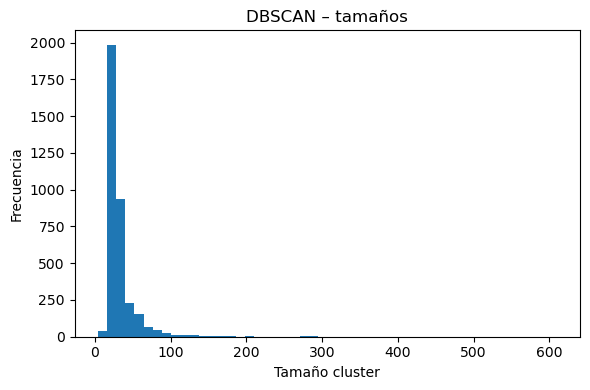

✅ End-to-end completo.


In [1]:

# 1) Config & helper
import os, json, subprocess, shutil
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

RAW_SRC_DIR = Path("./raw")
SAMPLE_NAME = "sample.laz"
DBSCAN_EPS = 0.8
DBSCAN_MINPTS = 20

ROOT = Path(".").resolve()
DATA = ROOT/"data"
RAW_DST_DIR = DATA/"raw"
PROC = DATA/"processed"
PIPES = ROOT/"pipelines"

RAW = RAW_DST_DIR / SAMPLE_NAME
LAS_HAG = PROC/"sample_hag.las"
LAS_VEG = PROC/"veg_gt2m.las"
LAS_DB  = PROC/"veg_gt2m_dbscan.las"
CSV_DBSCAN = PROC/"veg_gt2m_dbscan.csv"
CSV_CLEAN  = PROC/"veg_gt2m_dbscan_clean.csv"
PARQ_CLEAN = PROC/"veg_gt2m_dbscan_clean.parquet"

PIPE_HAG    = PIPES/"pipeline_make_hag.json"
PIPE_DBSCAN = PIPES/"pipeline_dbscan.json"

for d in [RAW_DST_DIR, PROC, PIPES]: d.mkdir(parents=True, exist_ok=True)

def run(cmd):
    print("$", " ".join(cmd))
    p = subprocess.run(cmd, capture_output=True, text=True)
    if p.stdout: print(p.stdout)
    if p.returncode != 0:
        if p.stderr: print(p.stderr)
        raise RuntimeError(f"Fallo: {' '.join(cmd)}")
    return p.stdout

print("=== Config ==="); print("ROOT:", ROOT); print("RAW destino:", RAW)

# 2) Preparar sample.laz
if not RAW.exists():
    candidates = sorted(RAW_SRC_DIR.glob("*.laz"))
    if not candidates:
        raise FileNotFoundError("Poné originales en ./raw o cambia RAW_SRC_DIR")
    src = candidates[0]; shutil.copy2(src, RAW); print("✅ Copiado", src, "→", RAW)
else:
    print("Usando RAW existente:", RAW)

run(["pdal","info",str(RAW),"--summary"])

# 3) Crear/actualizar pipelines
pipeline_hag = {
    "pipeline":[
        {"type":"readers.las","filename":str(RAW)},
        {"type":"filters.pmf","max_window_size":18,"slope":0.15,"initial_distance":0.5,"cell_size":1.0},
        {"type":"filters.hag_delaunay"},
        {"type":"writers.las","filename":str(LAS_HAG),"minor_version":4,"dataformat_id":6,"extra_dims":"all"}
    ]
}
PIPE_HAG.write_text(json.dumps(pipeline_hag, indent=2))

pipeline_dbscan = {
  "pipeline":[
    str(LAS_VEG),
    {"type":"filters.dbscan","min_points":DBSCAN_MINPTS,"eps":DBSCAN_EPS,"dimensions":"X,Y,Z"},
    {"type":"writers.las","filename":str(LAS_DB),"minor_version":4,"dataformat_id":6,"extra_dims":"all"},
    {"type":"writers.text","filename":str(CSV_DBSCAN),"format":"csv","order":"X,Y,Z,HeightAboveGround,ClusterID","keep_unspecified":False,"quote_header":False}
  ]
}
PIPE_DBSCAN.write_text(json.dumps(pipeline_dbscan, indent=2))

# 4) HAG
run(["pdal","pipeline",str(PIPE_HAG)])
hag_all = run(["pdal","info",str(LAS_HAG),"--all"])
print("¿HeightAboveGround?", "HeightAboveGround" in hag_all)

# 5) ≥2m
run(["pdal","translate",str(LAS_HAG),str(LAS_VEG),"range",
     "--filters.range.limits=HeightAboveGround[2:]",
     "--writers.las.minor_version=4",
     "--writers.las.dataformat_id=6",
     "--writers.las.extra_dims=all"])
veg_all = run(["pdal","info",str(LAS_VEG),"--all"])
print("¿veg_gt2m con HAG?", "HeightAboveGround" in veg_all)

# 6) DBSCAN
run(["pdal","pipeline",str(PIPE_DBSCAN)])

# 7) Limpieza pandas
usecols=["X","Y","Z","HeightAboveGround","ClusterID"]
dtypes={"X":"float32","Y":"float32","Z":"float32","HeightAboveGround":"float32","ClusterID":"int32"}
df = pd.read_csv(CSV_DBSCAN, usecols=usecols, dtype=dtypes)
df_clean = df[df["ClusterID"] != -1].copy()
df_clean.to_csv(CSV_CLEAN, index=False)
df_clean.to_parquet(PARQ_CLEAN, index=False)

print(f"Puntos originales: {len(df):,} | sin ruido: {len(df_clean):,}")
print("CSV clean →", CSV_CLEAN, "| Parquet →", PARQ_CLEAN)

# 8) Hist rápido
cluster_counts = (df_clean["ClusterID"].value_counts()
                  .rename_axis("ClusterID").reset_index(name="#puntos"))
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.hist(cluster_counts["#puntos"], bins=50); plt.xlabel("Tamaño cluster"); plt.ylabel("Frecuencia"); plt.title("DBSCAN – tamaños")
plt.tight_layout(); plt.show()

print("✅ End-to-end completo.")
